# Data Preprocessing

In [1]:
import pandas as pd
import torch
import seaborn as sns
import librosa
import numpy as np
import matplotlib.pyplot as plt
from utils import DATA_PATH, RAW_DATA_PATH

In [2]:
train_df = pd.read_feather(RAW_DATA_PATH / 'train.feather.lz4')
test_df = pd.read_feather(RAW_DATA_PATH / 'test.feather.lz4')

[]

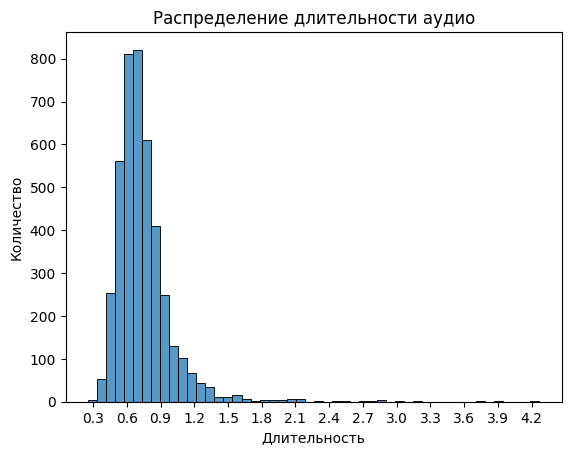

In [3]:
sr = train_df.loc[0, 'SR']
durations = train_df['Audio'].apply(lambda x: librosa.get_duration(y=x, sr=sr))

def plot_dur_dist(ax: plt.Axes) -> None:
    sns.histplot(durations, bins=50, ax=ax)
    ax.set_xlabel('Длительность')
    ax.set_ylabel('Количество')
    ax.set_xticks(np.arange(0, durations.max(), 0.3))
    ax.set_title('Распределение длительности аудио')
    
ax = plt.axes()
plot_dur_dist(ax)
plt.plot()

In [4]:
sr = train_df.loc[0, 'SR']

def process_data(df: pd.DataFrame) -> pd.DataFrame:
    df['MFCC'] = df['Audio'].apply(lambda y: librosa.feature.mfcc(y=y, sr=sr))
    df = df.copy()
    df.drop(['Audio', 'SR'], inplace=True, axis=1)
    df = df.reindex(columns=['Gender', 'Word ID', 'MFCC', 'Pronunciation'])
    df = df.reset_index(drop=True)
    return df

processed_train = process_data(train_df)
processed_test = process_data(test_df)

[]

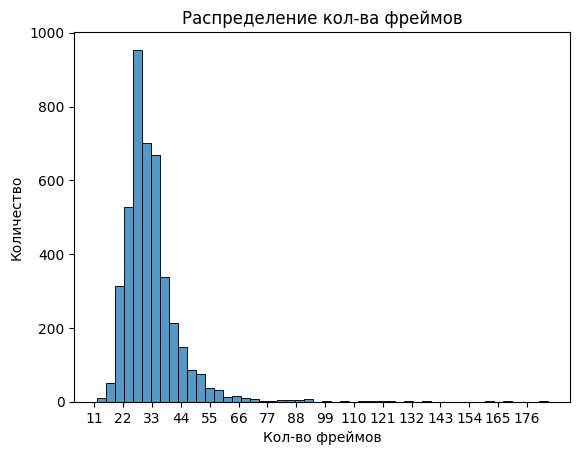

In [5]:
ax = plt.axes()
mfcc_frames = processed_train['MFCC'].apply(lambda x: x.shape[1])

def plot_frames_dist(ax: plt.Axes) -> None:
    sns.histplot(mfcc_frames, bins=50, ax=ax)
    ax.set_xlabel('Кол-во фреймов')
    ax.set_ylabel('Количество')
    ax.set_xticks(np.arange(0, mfcc_frames.max(), 11))
    ax.set_title('Распределение кол-ва фреймов')
    
plot_frames_dist(ax)
plt.plot()

[]

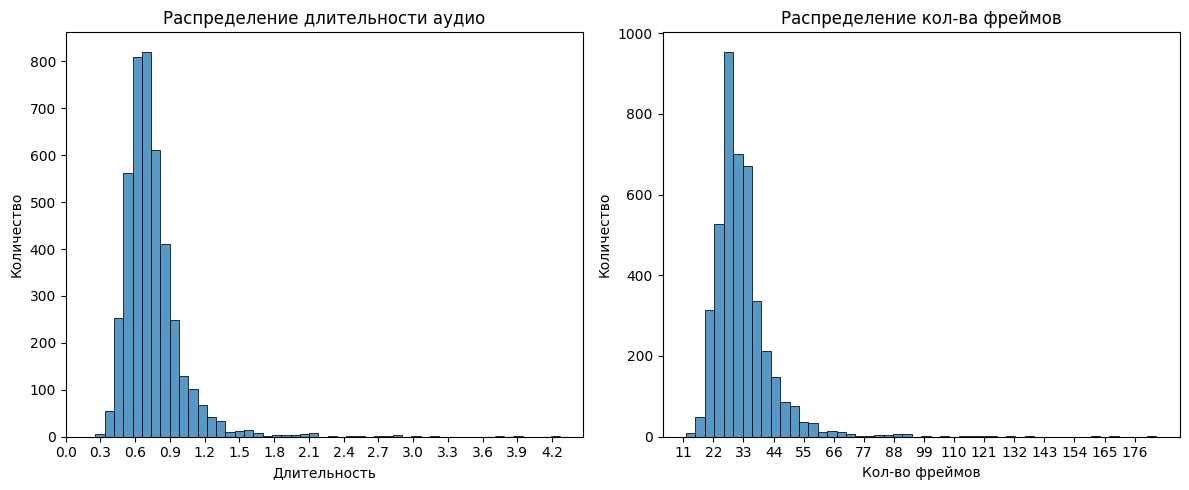

In [10]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_dur_dist(ax[0]), plot_frames_dist(ax[1])
plt.tight_layout()
plt.plot()

In [58]:
processed_train

,Gender,Word ID,MFCC,Pronunciation
0,0,38,"[[-101.343864, -57.68964, -79.96107, -105.1610...",0
1,0,95,"[[-410.06534, -366.34695, -353.6518, -351.3602...",0
2,1,18,"[[-318.4451, -294.80594, -301.74747, -296.1121...",0
3,1,50,"[[-389.58984, -343.82108, -248.69495, -142.996...",0
4,1,36,"[[-229.20363, -164.5397, -138.07838, -135.5245...",0
...,...,...,...,...
4232,1,20,"[[-523.33093, -506.92685, -518.53326, -524.831...",0
4233,0,59,"[[-251.34383, -203.18005, -200.48639, -179.738...",0
4234,1,100,"[[-586.50916, -602.75757, -607.3466, -565.0357...",0
4235,1,13,"[[-208.44614, -163.74918, -134.77841, -127.985...",0


In [109]:
from torch.nn.utils.rnn import pad_sequence

def data_to_dict(df: pd.DataFrame) -> dict:    
    mfcc_list = [torch.as_tensor(m.T, dtype=torch.float32) for m in df['MFCC']]

    lengths = torch.tensor([t.size(0) for t in mfcc_list], dtype=torch.long)  
    padded  = pad_sequence(mfcc_list, batch_first=True)  

    padded = padded.permute(0, 2, 1)

    data = {
        'gender':   torch.tensor(df['Gender'].values, dtype=torch.int8),
        'word_id':  torch.tensor(df['Word ID'].values, dtype=torch.int8),
        'mfcc':     padded,      
        'lengths':  lengths,     
        'label':    torch.tensor(df['Pronunciation'].values, dtype=torch.int8)
    }
    return data


In [110]:
train_dict = data_to_dict(processed_train)
test_dict = data_to_dict(processed_test)

In [112]:
torch.save(train_dict, DATA_PATH / 'processed/train.pt')
torch.save(test_dict, DATA_PATH / 'processed/test.pt')

In [ ]:
test_dict['mfcc']

torch.Size([4237, 20, 184])